In [3]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import logging
import datetime
import importlib
import rnn_base
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim
import sys
import random
import numpy as np

import pandas as pd
import os
from gensim.models import word2vec
import torch
from torch.utils import data
from torch import nn
from gensim.models import Word2Vec

importlib.reload(rnn_base)


<module 'rnn_base' from 'C:\\Users\\rongjoker\\PycharmProjects\\ephemeralP\\pt\\rnn_base.py'>

In [9]:
batch_size = 128
home_dir = '../data/kaggle_toxic/input/'
path_prefix = "../data/kaggle_toxic/save/"

In [10]:

for dirname, _, filenames in os.walk(home_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/kaggle_toxic/input/sample_submission.csv.zip
../data/kaggle_toxic/input/test.csv.zip
../data/kaggle_toxic/input/test_labels.csv.zip
../data/kaggle_toxic/input/train.csv.zip


In [39]:
df_train = pd.read_csv(os.path.join(home_dir,'train.csv.zip'),error_bad_lines=False)

In [40]:
df_test = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)

In [43]:
df_test.iloc[0:4]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."


In [44]:
df_test_labels = pd.read_csv(os.path.join(home_dir,'test_labels.csv.zip'),error_bad_lines=False)

In [45]:
df_test_labels.iloc[0:4]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1


In [46]:
sample_submission = pd.read_csv(os.path.join(home_dir,'sample_submission.csv.zip'),error_bad_lines=False)

In [47]:
sample_submission.iloc[0:4]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5


In [29]:
df_labeledTrainData.keys()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [30]:
df_labeledTrainData.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [31]:
type(df_labeledTrainData)

pandas.core.frame.DataFrame

In [37]:
df_labeledTrainData.iloc[0:4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


In [38]:
df_labeledTrainData[df_labeledTrainData.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [124]:
def load_data_imdb(batch_size, num_steps=500):
    df_labeledTrainData = pd.read_csv(os.path.join(home_dir,'labeledTrainData.tsv.zip'),sep = "\t",error_bad_lines=False)
    train_x, train_y = list(df_labeledTrainData['review']), list(df_labeledTrainData['sentiment'])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    train_slices = random.sample(list(range(n_train)), 20000)
    test_slices = list(set(range(n_train)) - set(train_slices))
    
    train_data = (train_x[train_slices], list(train_y[train_slices]))
    test_data = (train_x[test_slices], list(train_y[test_slices]))
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    # vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1], dtype=torch.long)),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1], dtype=torch.long)),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter

In [157]:
def load_data_imdb_infer(batch_size, num_steps=500):
    df_testData = pd.read_csv(os.path.join(home_dir,'testData.tsv.zip'),sep = "\t",error_bad_lines=False)
    infer_x = list(df_testData['review'])

    infer_tokens = d2l.tokenize(infer_x, token='word')
    infer_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in infer_tokens])
    # print(infer_features[0])
    infer_iter = d2l.load_array((infer_features,infer_features),
                               batch_size,
                               is_train=False)
    return infer_iter

In [111]:
def rnn_train(glove_embedding, train_iter, test_iter,vocab, lr, epochs):
    model_path = os.path.join(path_prefix, 'cifar_%s.pth' % epochs)
    def init_weights(module):
        if type(module) == nn.Linear:
            nn.init.xavier_uniform_(module.weight)
        if type(module) == nn.LSTM:
            for param in module._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(module._parameters[param])

    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    net = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
    net.apply(init_weights)
    # Loading Pretrained Word Vectors
    # glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    print('embeds.shape:', embeds.shape)
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")

    net.embedding.weight.data.copy_(embeds)
    net.embedding.weight.requires_grad = False

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)
    torch.save(net.state_dict(), model_path)

In [116]:
batch_size = 128
# tiny dataset
train_iter, test_iter = load_data_imdb(batch_size)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [140]:
for i,(x,y) in enumerate(train_iter):
    print(y)
    print(y.to(torch.int64))
    break

tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0])


In [158]:
_infer_iter = load_data_imdb_infer(batch_size)

In [159]:
len(_infer_iter)

196

In [162]:
for i,y in enumerate(_infer_iter):
    print(y)
    break

[tensor([[12373, 31579, 17310,  ...,  3680,  3680,  3680],
        [15870, 35403, 32451,  ...,  3680,  3680,  3680],
        [ 4002, 31579, 18148,  ...,  3680,  3680,  3680],
        ...,
        [ 9589, 41418, 45792,  ...,  3680,  3680,  3680],
        [ 9589, 30299, 35925,  ...,  3680,  3680,  3680],
        [15820, 38925, 48796,  ...,  3680,  3680,  3680]]), tensor([[12373, 31579, 17310,  ...,  3680,  3680,  3680],
        [15870, 35403, 32451,  ...,  3680,  3680,  3680],
        [ 4002, 31579, 18148,  ...,  3680,  3680,  3680],
        ...,
        [ 9589, 41418, 45792,  ...,  3680,  3680,  3680],
        [ 9589, 30299, 35925,  ...,  3680,  3680,  3680],
        [15820, 38925, 48796,  ...,  3680,  3680,  3680]])]


loss 0.340, train acc 0.853, test acc 0.829
3591.4 examples/sec on [device(type='cuda', index=0)]


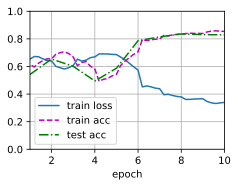

In [184]:
# lr, num_epochs = 0.01, 5
EPOCHS = 10
LR = 0.001

rnn_train(glove_embedding, train_iter, test_iter, vocab, LR, EPOCHS)

In [185]:
def testing(test_loader):
    model_path = os.path.join(path_prefix, 'cifar_10.pth')
    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    model = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
    model.load_state_dict(torch.load(model_path))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    ret_output = []
    with torch.no_grad():
        for i, (inputs,_inputs) in enumerate(test_loader):
            inputs = inputs.to(d2l.try_gpu(), dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            label = torch.argmax(outputs, dim=1)
            # print(label)
            # outputs[outputs>=0.5] = 1 # 大於等於0.5為負面
            # outputs[outputs<0.5] = 0 # 小於0.5為正面
            ret_output += label.tolist()
    
    return ret_output

In [186]:
ret_output = testing(_infer_iter)
df_pred = pd.read_csv(os.path.join(home_dir,'testData.tsv.zip'),sep = "\t",error_bad_lines=False)
kk = list(df_pred["id"])

# 寫到csv檔案供上傳kaggle
submission = pd.DataFrame({"id":kk,"sentiment":ret_output})
submission.to_csv(os.path.join(path_prefix, 'submission.csv'), index = False) #accuracy 0.97604
print("Finish Predicting")

Finish Predicting
